In [1]:
import os
import numpy as np
import argparse

import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral_pyg.main import SPIRAL_integration_pyG
from spiral_pyg.pyG_layers import *
R_dirs="/home/tguo/tguo2/miniconda3/envs/pyg/lib/R"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
# ############seed#############
seed=1234
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

In [3]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]
samples=sample_name[0:12]
SEP=','
net_cate='_KNN_'
knn=6

P_WALK=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn

feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
flags1=str(samples[0])
for i in range(1,len(samples)):
    flags1=flags1+'-'+str(samples[i])
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_features-1.txt")
    edge_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_label-1.txt")
    coord_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_positions-1.txt")
    flags=flags+'_'+str(samples[i])
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
M=12

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
# parser.add_argument('--beta', type=float, default=0.2, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default='mean', help='Function of aggregator.')
parser.add_argument('--num_samples', type=list, default=[knn,knn], help='number of neighbors to sample.')

parser.add_argument('--P_WALK', type=int, default=P_WALK, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')
parser.add_argument('--P', type=float, default=1.0, help=' likelihood of immediately revisiting a node in the walk.')
parser.add_argument('--Q', type=float, default=1.0, help='Control parameter to interpolate between breadth-first strategy and depth-first strategy.')



parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=1024, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.')
parser.add_argument('--random_seed', type=float, default=8, help='random seed.')

params,unknown=parser.parse_known_args()

In [5]:
SPII=SPIRAL_integration_pyG(params,samples,feat_file,edge_file,meta_file)
SPII.train()
SPII.model.eval()
all_embed,ae_out=SPII.model.full_forward(SPII.FEAT[:,:-1], SPII.edge_index,SPII.params.lamda,SPII.de_act,SPII.cl_act)
ae_embed,gs_embed,embed=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
names=['SPIRAL_'+str(i) for i in np.arange(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.meta.index,columns=names)
meta=SPII.meta.values
# embed1.to_csv(dirs+"gtt_output/SPIRAL_pyg"+flags+"_embed_"+str(SPII.params.batch_size)+".csv")

--------------------------------
Training.
processed: 100: 100%|█████████████████████████████████████| 100/100 [1:33:22<00:00, 56.03s/it, AE_loss=0.0466, CLAS_loss=2.41, DISC_loss=2.43, GS_loss=1.03, total_loss=156]


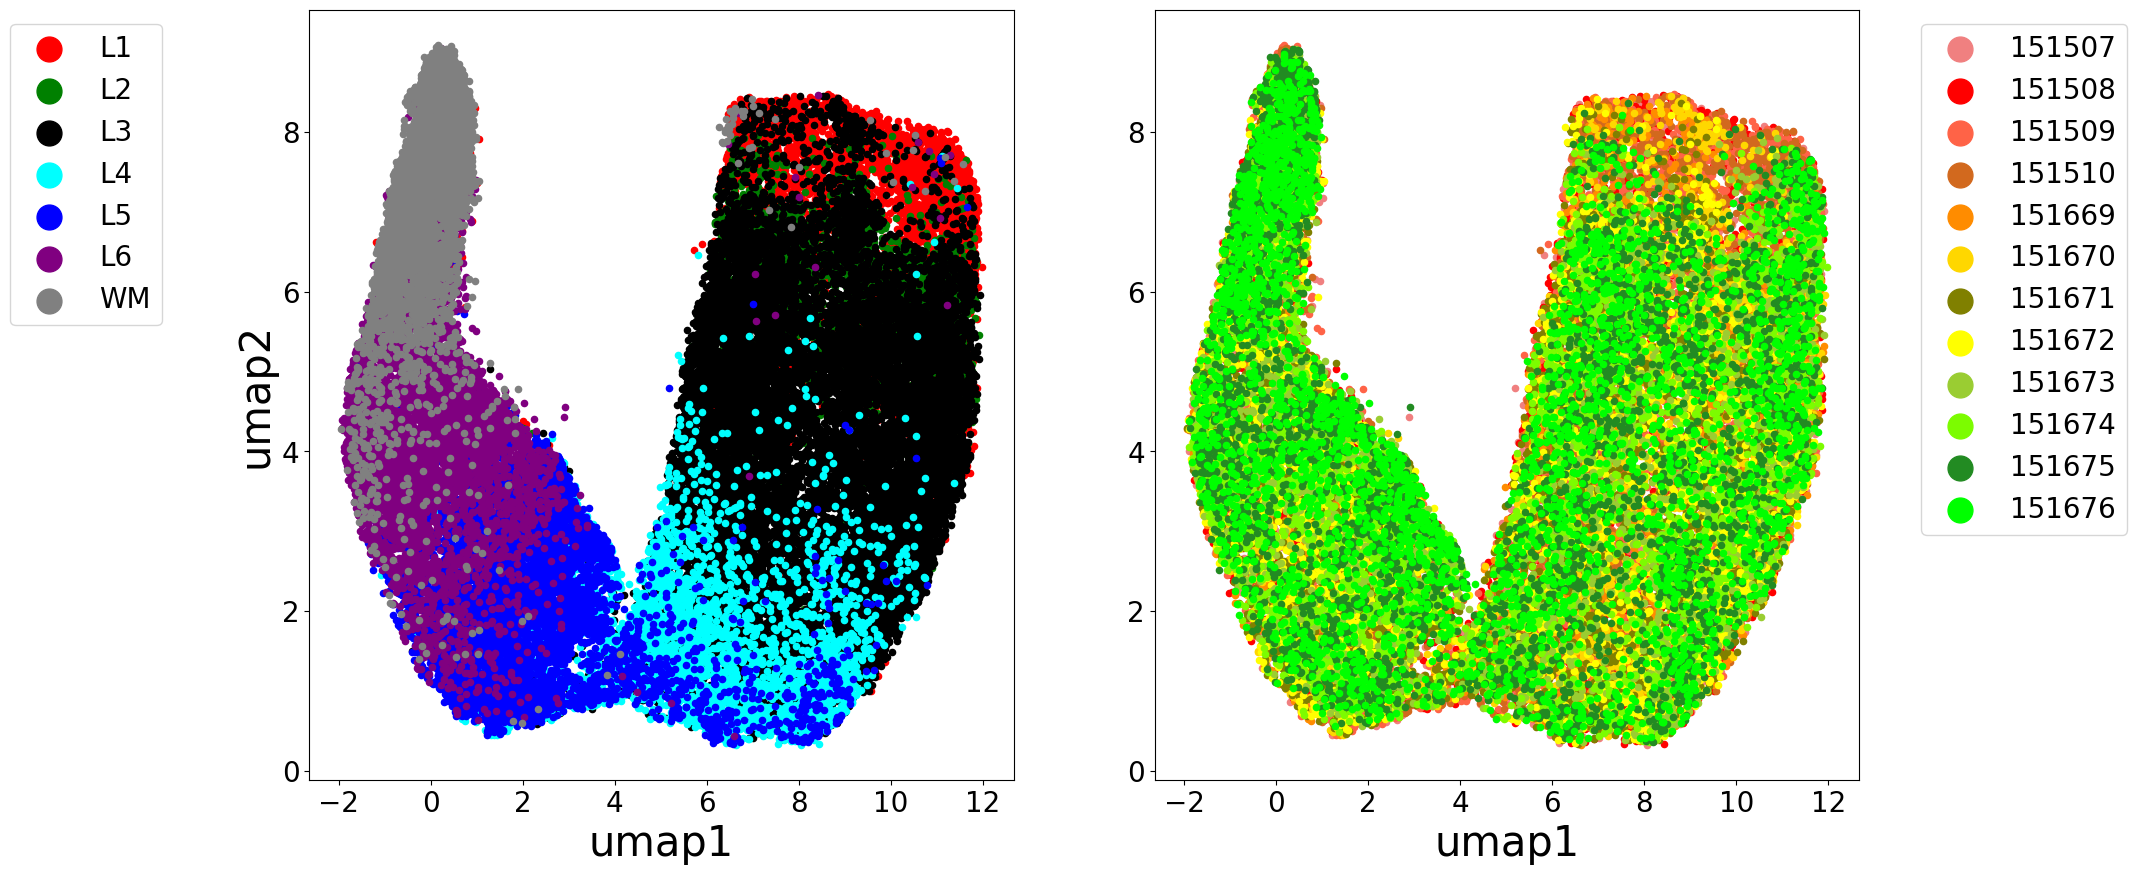

In [8]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
# x=PCA(n_components=30).fit_transform(SPII.feat)
# embed=pd.read_csv(dirs+"gtt_output/AGC_embed"+flags+"_xent.csv",index_col=0,header=0).values
celltype=meta[:,0]
batch=meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
umap_mat=umap.UMAP().fit_transform(embed1.values[:,4:])
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour2[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour1[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)